In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from numpy.linalg import svd
%matplotlib inline 

In [2]:
#load data
mapping=pd.read_csv('comments_employee_mapping.csv').dropna()
likes=pd.read_csv('comments_likeability.csv').dropna()
attr=pd.read_csv('employee_attrition.csv').dropna()
hap=pd.read_csv('happiness_level.csv').dropna()

#read dates as pandas date-type
attr['lastParticipationDate']=pd.to_datetime(attr['lastParticipationDate'],infer_datetime_format=True)
mapping['commentDate']=pd.to_datetime(mapping['commentDate'],infer_datetime_format=True)
hap['voteDate']=pd.to_datetime(hap['voteDate'],infer_datetime_format=True)

#merge employee number and company alias into id
for d in [mapping,likes,attr,hap]:
    d['id']=d['employee'].map(str)+d['companyAlias']

#linearize dates
attr['ordinal']=[x.toordinal() for x in attr['lastParticipationDate']]
mapping['ordinal']=[x.toordinal() for x in mapping['commentDate']]
hap['ordinal']=[x.toordinal() for x in hap['voteDate']]

/Users/vaibhavnayel/anaconda/lib/python2.7/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname CET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/Users/vaibhavnayel/anaconda/lib/python2.7/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname CEST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [122]:
l=np.array(np.load('likes_matrix_sparse_arranged.npy')[0].todense())
#l=l[:,(l!=0).sum(0)>2]
c=np.array(np.load('comment_matrix_sparse_arranged.npy')[0].todense())
h=np.load('HappinessFeature.npy').tolist()
h=np.array([h[e] for e in attr.id])

g=np.load('comment_goodness_scores.npy').tolist()
l_w=np.array(np.load('likes_matrix_sparse_arranged.npy')[0].todense())
com_dict=np.load('likes_matrix_sparse_arranged.npy')[1]
for k in g:
    try:l_w[:,com_dict[g]]*=g[k]
    except:pass
l_w=l_w/((l!=0).sum(1) +1 )[:,np.newaxis]
l_w=l_w[:,(l!=0).sum(0)>5]


In [171]:
#data=np.hstack([l,c,pd.get_dummies(attr.companyAlias),(h)[:,np.newaxis],attr.numVotes[:,np.newaxis]])
data=np.hstack([l_w,pd.get_dummies(attr.companyAlias),((attr.ordinal-attr.ordinal.mean())/attr.ordinal.std())[:,np.newaxis],(h/(attr.numVotes+1))[:,np.newaxis],attr.numVotes[:,np.newaxis]])

X_train, X_test, y_train, y_test = train_test_split(
    data,attr.stillExists,stratify=attr.stillExists, test_size=0.33, random_state=42)


In [140]:
pca = PCA(n_components=1000)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)

In [102]:
svd = TruncatedSVD(n_components=100)
svd.fit(X_train)
X_train = svd.transform(X_train)
X_test=svd.transform(X_test)


(array([4.131e+03, 3.881e+03, 3.388e+03, 3.070e+03, 2.604e+03, 2.328e+03,
        2.105e+03, 1.758e+03, 1.569e+03, 1.356e+03, 1.184e+03, 1.007e+03,
        9.370e+02, 8.420e+02, 7.440e+02, 6.270e+02, 6.180e+02, 5.500e+02,
        4.820e+02, 4.290e+02, 4.190e+02, 3.180e+02, 3.140e+02, 2.820e+02,
        2.430e+02, 2.090e+02, 2.370e+02, 1.740e+02, 1.670e+02, 1.220e+02,
        1.250e+02, 1.210e+02, 9.600e+01, 9.200e+01, 8.100e+01, 7.200e+01,
        6.200e+01, 5.100e+01, 4.400e+01, 3.600e+01, 4.100e+01, 3.300e+01,
        2.100e+01, 1.700e+01, 1.900e+01, 2.400e+01, 1.300e+01, 1.600e+01,
        1.600e+01, 1.300e+01, 1.200e+01, 1.100e+01, 6.000e+00, 9.000e+00,
        1.000e+01, 1.000e+00, 5.000e+00, 5.000e+00, 2.000e+00, 5.000e+00,
        3.000e+00, 0.000e+00, 3.000e+00, 5.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

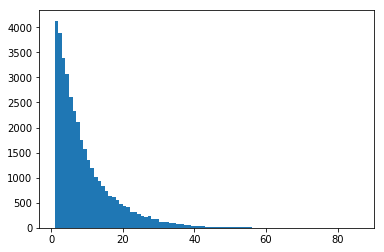

In [26]:
plt.hist((l!=0).sum(0),bins=(l!=0).sum(0).max()-1)

0.8930041152263375


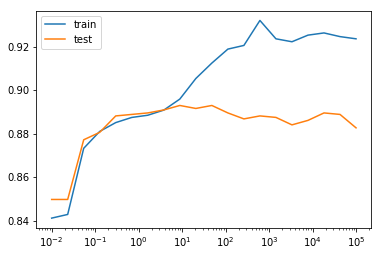

In [196]:
tr,te=[],[]
x=np.logspace(-2,5,20)
for c in x:
    clf=LogisticRegression(C=c,penalty='l2')
    clf.fit(X_train,y_train)
    tr.append(clf.score(X_train,y_train))
    te.append(clf.score(X_test,y_test))
plt.plot(x,tr,label='train')
plt.plot(x,te,label='test')
plt.xscale('log')
plt.legend()
print max(te)

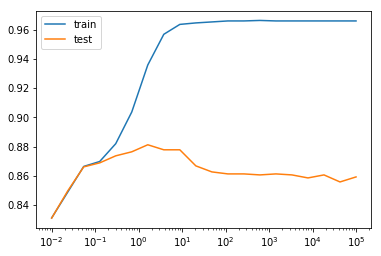

In [72]:
tr,te=[],[]
x=np.logspace(-2,5,20)
for c in x:
    clf=LogisticRegression(C=c,penalty='l1')
    clf.fit(X_train,y_train)
    tr.append(clf.score(X_train,y_train))
    te.append(clf.score(X_test,y_test))
plt.plot(x,tr,label='train')
plt.plot(x,te,label='test')
plt.xscale('log')
plt.legend()

In [74]:
pca = PCA(n_components=50)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)

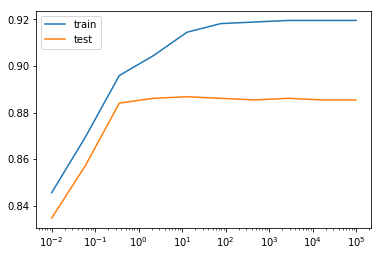

In [77]:
tr,te=[],[]
x=np.logspace(-2,5,10)
for c in x:
    clf=LogisticRegression(C=c)
    clf.fit(X_train,y_train)
    tr.append(clf.score(X_train,y_train))
    te.append(clf.score(X_test,y_test))
plt.plot(x,tr,label='train')
plt.plot(x,te,label='test')
plt.xscale('log')
plt.legend()

In [195]:
l=np.load('likes_matrix_sparse_arranged.npy')[0].todense()
c=np.load('comment_matrix_sparse_arranged.npy')[0].todense()
h=np.load('HappinessFeature.npy').tolist()
h=np.array([h[e] for e in attr.id])

data=compress_svd(np.hstack([l,c,pd.get_dummies(attr.companyAlias),(h)[:,np.newaxis],attr.numVotes[:,np.newaxis]]),10)

X_train, X_test, y_train, y_test = train_test_split(
    data,attr.stillExists,stratify=attr.stillExists, test_size=0.33, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [2, 4418]

In [ ]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)
clf.score(X_train,y_train)
clf.score(X_test,y_test)

In [75]:
g=np.load('comment_goodness_scores.npy').tolist()
l_w=np.array(np.load('likes_matrix_sparse_arranged.npy')[0].todense())
com_dict=np.load('likes_matrix_sparse_arranged.npy')[1]
for k in g:
    try:l_w[:,com_dict[g]]*=g[k]
    except:pass
l_w=l_w/((l!=0).sum(1) +1 )[:,np.newaxis]

In [118]:
X_train.std(0)

array([7.39764729e+01, 2.57460904e+01, 3.44633199e-01, 2.82769546e-01,
       2.72409737e-01, 2.54435121e-01, 2.34074073e-01, 2.30195378e-01,
       2.26310527e-01, 2.13508846e-01, 1.95786163e-01, 1.93798722e-01,
       1.90001204e-01, 1.83095032e-01, 1.78432662e-01, 1.73818300e-01,
       1.46690810e-01, 1.37581467e-01, 1.28780000e-01, 1.23736079e-01,
       1.19499945e-01, 1.11068112e-01, 1.06102864e-01, 1.03955672e-01,
       8.73239045e-02, 8.17248212e-02, 7.88541740e-02, 7.64413534e-02,
       7.40814119e-02, 6.95017217e-02, 6.19523128e-02, 5.68488771e-02,
       5.51405869e-02, 5.32303452e-02, 5.21958105e-02, 5.19872080e-02,
       4.54242856e-02, 2.63171576e-02, 1.80925060e-02, 1.59008850e-02,
       1.45580628e-02, 1.34694462e-02, 1.31611667e-02, 1.31259704e-02,
       1.31229589e-02, 1.29880356e-02, 1.24183357e-02, 1.17900008e-02,
       1.13727214e-02, 1.10751471e-02, 1.09166731e-02, 1.08859038e-02,
       1.07971263e-02, 1.07108205e-02, 1.06678175e-02, 1.03918995e-02,
      

In [197]:
clf=MLPClassifier(hidden_layer_sizes=[500,100],verbose=True,learning_rate='adaptive')
clf.fit(X_train,y_train)
print clf.score(X_train,y_train)
print clf.score(X_test,y_test)

Iteration 1, loss = 0.50277325
Iteration 2, loss = 0.40563973
Iteration 3, loss = 0.36252779
Iteration 4, loss = 0.31494494
Iteration 5, loss = 0.27597724
Iteration 6, loss = 0.26456439
Iteration 7, loss = 0.23578563
Iteration 8, loss = 0.26254227
Iteration 9, loss = 0.21377438
Iteration 10, loss = 0.23782551
Iteration 11, loss = 0.22577320
Iteration 12, loss = 0.19487567
Iteration 13, loss = 0.18172554
Iteration 14, loss = 0.17593798
Iteration 15, loss = 0.18077391
Iteration 16, loss = 0.16555288
Iteration 17, loss = 0.15598444
Iteration 18, loss = 0.15241922
Iteration 19, loss = 0.15622505
Iteration 20, loss = 0.14929748
Iteration 21, loss = 0.17380697
Iteration 22, loss = 0.17918995
Iteration 23, loss = 0.16851319
Iteration 24, loss = 0.13731398
Iteration 25, loss = 0.13244534
Iteration 26, loss = 0.12899839
Iteration 27, loss = 0.12326185
Iteration 28, loss = 0.13385751
Iteration 29, loss = 0.15931734
Iteration 30, loss = 0.14327916
Iteration 31, loss = 0.12414516
Iteration 32, los

In [90]:
print clf.score(X_train,y_train)
print clf.score(X_test,y_test)

0.947972972972973
0.8909465020576132


In [183]:
bdt = AdaBoostClassifier(LogisticRegression(C=1),
                         n_estimators=300)

bdt.fit(X_train, y_train)
print bdt.score(X_train,y_train)
print bdt.score(X_test,y_test)

0.8841216216216217
0.8847736625514403


0.8807432432432433

0.8820301783264746

In [184]:
bagging = BaggingClassifier(LogisticRegression(C=1),
                            max_samples=0.5, max_features=0.5,n_estimators=20).fit(X_train,y_train)
print bagging.score(X_train,y_train)
print bagging.score(X_test,y_test)

0.8429054054054054
0.8511659807956105


In [190]:

def compress_svd(image,k):
    """
    Perform svd decomposition and truncated (using k singular values/vectors) reconstruction
    returns
    --------
      reconstructed matrix reconst_matrix, array of singular values s
    """
    U,s,V = svd(image,full_matrices=False)
    reconst_matrix = np.dot(U[:,:k],np.dot(np.diag(s[:k]),V[:k,:]))
   
    return reconst_matrix,s

In [194]:
l_=compress_svd(l,10)

(array([[ 0.00044172, -0.00032226,  0.00051468, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00772803, -0.00563797,  0.00900443, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00025142, -0.00018343,  0.00029295, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([1.04375562e+02, 9.66389190e+01, 8.65954773e+01, ...,
        7.33991748e-16, 7.08551229e-16, 4.09172025e-16]))